In [1]:
%load_ext autoreload
%autoreload 2

# **Quantum Generative Adversarial Networks for Monte Carlo Simulations**
---
### **Description**
Implementation of Quantum Generative Adversarial Networks trained to learn the probability distribution of four different datasets belonging to envents which can be simulated through Monte Carlo simulations and encode it as a quantum state to generate synthetic data following the distribution of the training datasets.

<br>

### **Structure**
**Part 1**: Data Generation

**Part 2**: qGAN Initialization

**Part 3**: Model Training

**Part 4**: Model Evaluation

<br>

## **Generative Adversarial Networks (GANs)**
Generative Adversarial Networks aim to produce data that resembles the original training data. ...


##### Import libraries

In [2]:
from python_package.qGAN import Discriminator, QuantumAnsatz, QuantumGenerator, Dataset
from python_package.simulations import MonteCarlo
from torch.utils.data import DataLoader
from scipy.stats import wasserstein_distance, entropy
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch
import pennylane as qml
import matplotlib.pyplot as plt

In [3]:
# Set the random seed for reproducibility
seed = 13
torch.manual_seed(seed)
np.random.seed(seed)

## **Data Generation**

In [4]:
# Coin toss simulation

coin_tosses = MonteCarlo.coin_toss(n_samples=100000, coins=10)

# Get the pseudo probability distribution
prob_dist = MonteCarlo.probability_distribution_1D(samples=coin_tosses, batch_size=10000, bins=16)

In [5]:
# Create the data loader instance
dataset = Dataset(prob_dist)
dataloader = DataLoader(dataset, batch_size=1)

## **qGAN initialization**

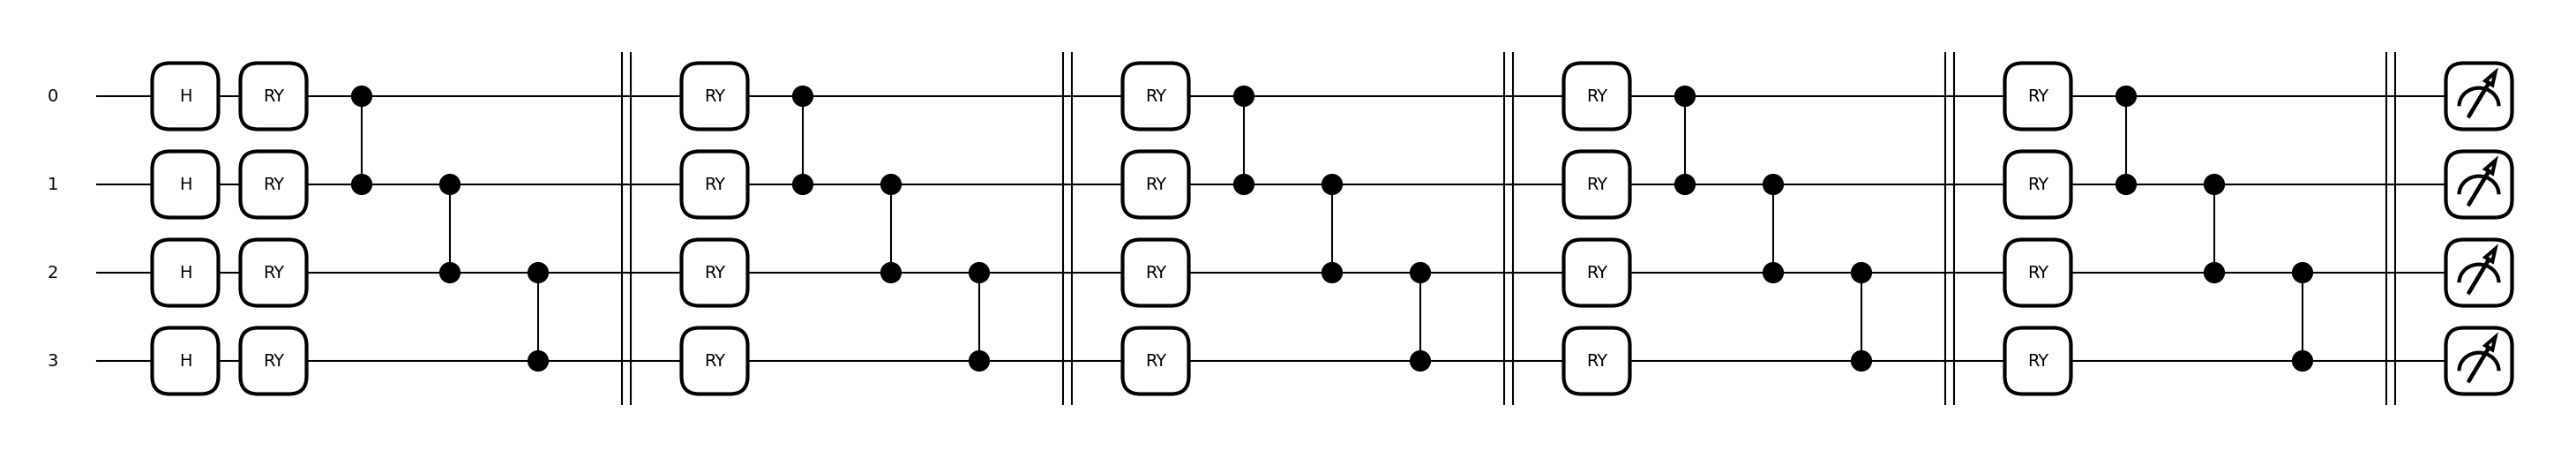

In [6]:
n_qubits = 4 # Number of qubits in the circuit
q_depth = 5 # Number of layers in the circuit

# Visualization of the parametrized circuit
weights = torch.rand(1, n_qubits*q_depth)  
ansatz = QuantumAnsatz(n_qubits, q_depth)
qml.draw_mpl(ansatz.circuit())(weights=weights)
plt.show()

In [33]:
# Initialization of classical discriminator and Quantum generator
discriminator = Discriminator(input_shape=16, layers=[50, 20]).to(ansatz.device)
generator = QuantumGenerator(n_qubits, q_depth, ansatz.circuit()).to(ansatz.device)

# Discriminator features 
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=16, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=20, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


## **Model Training**

In [8]:
lrG = 0.3  # Learning rate for the generator
lrD = 0.01  # Learning rate for the discriminator
num_iter = 500  # Number of training iterations

# Binary cross entropy
criterion = nn.BCELoss()

# Optimizers
optD = optim.SGD(discriminator.parameters(), lr=lrD)
optG = optim.SGD(generator.parameters(), lr=lrG)

real_labels = torch.full((1,), 1.0, dtype=torch.float, device=ansatz.device)
fake_labels = torch.full((1,), 0.0, dtype=torch.float, device=ansatz.device)

# Iteration counter
counter = 0

# Collect images for plotting later
disc_loss = []
gen_loss = []

In [9]:
while True:
    for i, data in enumerate(dataloader):

        # Data for training the discriminator
        real_data = data.to(ansatz.device)
        fake_data = generator()

        # Training the discriminator
        discriminator.zero_grad()
        outD_real = discriminator(real_data).view(-1)
        outD_fake = discriminator(fake_data.detach()).view(-1)

        errD_real = criterion(outD_real, real_labels)
        errD_fake = criterion(outD_fake, fake_labels)
        
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        

        optD.step()
        

        # Training the generator
        generator.zero_grad()
        outD_fake = discriminator(fake_data).view(-1)
        errG = criterion(outD_fake, real_labels)
        

        errG.backward()
        optG.step()

        

    # Show loss values
    if counter % 10 == 0:
        print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}')
        gen_loss.append(errG.detach())
        disc_loss.append(errD.detach())

    counter += 1
    if counter == num_iter:
        break



Iteration: 0, Discriminator Loss: 1.389, Generator Loss: 0.748
Iteration: 10, Discriminator Loss: 1.376, Generator Loss: 0.727
Iteration: 20, Discriminator Loss: 1.370, Generator Loss: 0.713
Iteration: 30, Discriminator Loss: 1.386, Generator Loss: 0.694
Iteration: 40, Discriminator Loss: 1.381, Generator Loss: 0.698
Iteration: 50, Discriminator Loss: 1.391, Generator Loss: 0.689
Iteration: 60, Discriminator Loss: 1.389, Generator Loss: 0.693
Iteration: 70, Discriminator Loss: 1.387, Generator Loss: 0.695
Iteration: 80, Discriminator Loss: 1.385, Generator Loss: 0.695
Iteration: 90, Discriminator Loss: 1.384, Generator Loss: 0.694
Iteration: 100, Discriminator Loss: 1.384, Generator Loss: 0.694
Iteration: 110, Discriminator Loss: 1.383, Generator Loss: 0.694
Iteration: 120, Discriminator Loss: 1.383, Generator Loss: 0.694
Iteration: 130, Discriminator Loss: 1.383, Generator Loss: 0.693
Iteration: 140, Discriminator Loss: 1.383, Generator Loss: 0.693
Iteration: 150, Discriminator Loss: 

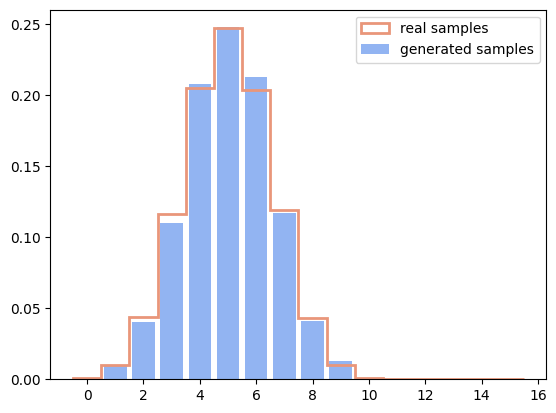

In [10]:
excluded_states = [0, 10, 11, 12, 13, 14, 15]
gen = generator.filtered_distribution(shots=100000, excluded_states=excluded_states)

plt.hist(coin_tosses, bins=16, align='left', range=[0, 16], rwidth=0.8, density=True, color="darksalmon", label="real samples", histtype="step", linewidth=2)
plt.hist(gen, bins=16, align='left', range=[0, 16], rwidth=0.8, density=True, color="cornflowerblue", alpha=0.7, label="generated samples")
plt.legend()
plt.show()

## **Model Evaluation**

In [11]:
# Frechet Distance

def frechet_distance(real_data, generated_data):
    mu_r = np.mean(real_data)
    mu_g = np.mean(generated_data)
    var_r = np.var(real_data)
    var_g = np.var(generated_data)

    mean_diff = mu_r - mu_g
    cov_mean = np.sqrt(var_r * var_g)

    distance = mean_diff**2 + var_r + var_g - 2 * cov_mean
    return distance



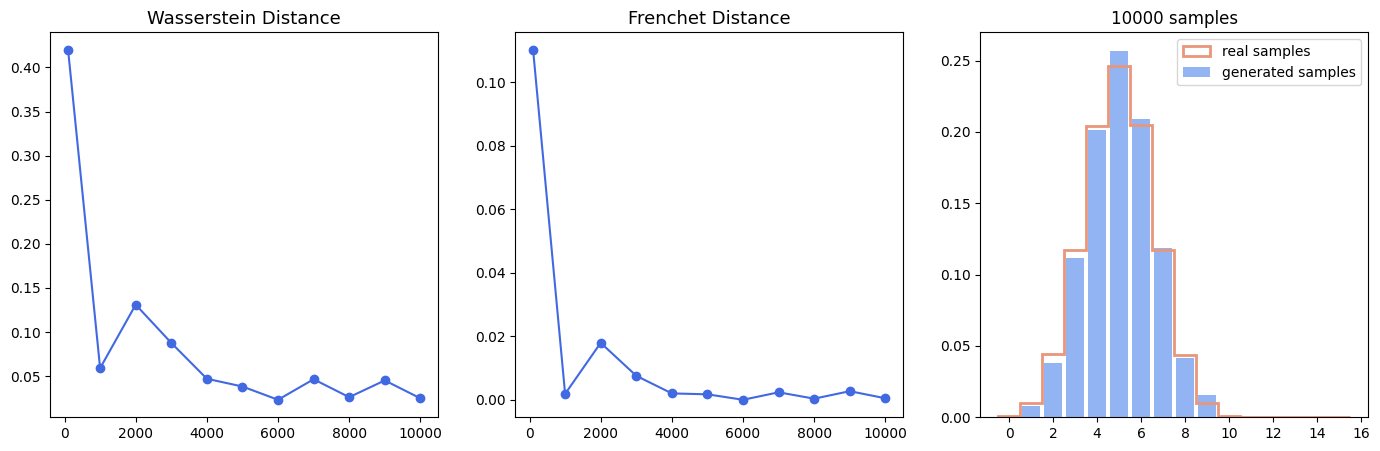

In [30]:
excluded_states = [0, 10, 11, 12, 13, 14, 15]
N_samples = [100, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
w_distance = []
f_distance = []
entropy_metric = []

for n in N_samples:
    real_samples = MonteCarlo.coin_toss(n_samples=n, coins=10)
    gen_samples = generator.filtered_distribution(shots=n, excluded_states=excluded_states)
    w_distance.append(wasserstein_distance(real_samples, gen_samples)) 
    f_distance.append(frechet_distance(real_samples, gen_samples))
    entropy_metric.append(entropy(real_samples, gen_samples))

real_samples = MonteCarlo.coin_toss(n_samples=1000000, coins=10)
gen_samples = generator.filtered_distribution(shots=10000, excluded_states=excluded_states)

fig, axs = plt.subplots(1, 3, figsize=(17, 5))
axs[0].plot(N_samples, w_distance, marker="o", color="royalblue")
axs[0].set_title("Wasserstein Distance", fontsize=13)
axs[1].plot(N_samples, f_distance, marker="o", color="royalblue")
axs[1].set_title("Frenchet Distance", fontsize=13)
axs[2].hist(real_samples, bins=16, align='left', range=[0, 16], rwidth=0.8, density=True, color="darksalmon", label="real samples", histtype="step", linewidth=2)
axs[2].hist(gen_samples, bins=16, align='left', range=[0, 16], rwidth=0.8, density=True, color="cornflowerblue", alpha=0.7, label="generated samples")
axs[2].legend()
axs[2].set_title("10000 samples")
plt.show()